In [3]:
import pandas as pd
import plotly.express as px
from datetime import datetime

# Load the data from the cleaned up CSV file
df = pd.read_csv('docs/cleansdge2023.csv')

# Display the first few rows of the DataFrame

print(df.head())
# Combine the Date and Start Time columns

df['Timestamp'] = df['Date'] + ' ' + df['Start Time']

# Convert the Timestamp column to datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.set_index('Date')

# Display the first few rows of the DataFrame to check the result
print(df.head())

        Date Start Time  Duration  Consumption  Generation    Net
0  11/8/2022   12:00 AM        15        0.150         0.0  0.150
1  11/8/2022   12:15 AM        15        0.145         0.0  0.145
2  11/8/2022   12:30 AM        15        0.130         0.0  0.130
3  11/8/2022   12:45 AM        15        0.115         0.0  0.115
4  11/8/2022    1:00 AM        15        0.100         0.0  0.100


/var/folders/5j/rjnddyfx02q2d15cld1tf7j80000gn/T/ipykernel_6021/2234435962.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Timestamp'] = pd.to_datetime(df['Timestamp'])


          Start Time  Duration  Consumption  Generation    Net  \
Date                                                             
11/8/2022   12:00 AM        15        0.150         0.0  0.150   
11/8/2022   12:15 AM        15        0.145         0.0  0.145   
11/8/2022   12:30 AM        15        0.130         0.0  0.130   
11/8/2022   12:45 AM        15        0.115         0.0  0.115   
11/8/2022    1:00 AM        15        0.100         0.0  0.100   

                    Timestamp  
Date                           
11/8/2022 2022-11-08 00:00:00  
11/8/2022 2022-11-08 00:15:00  
11/8/2022 2022-11-08 00:30:00  
11/8/2022 2022-11-08 00:45:00  
11/8/2022 2022-11-08 01:00:00  


In [ ]:
# Check the shape of the DataFrame
print(df.shape)

# Check the column names and data types
print(df.dtypes)

# Check for missing values
print(df.isnull().sum())

# Get summary statistics for numerical columns
print(df.describe())

# Plot some of the data (you'll need to import matplotlib for this)
import matplotlib.pyplot as plt
df['Net'].plot()
plt.show()

In [24]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime

class EnergyData:
    TOU_rates = [0, 0.81629, 0.48129, 0.15351, 0.51149, 0.44775, 0.1452]

    def __init__(self, file_path):
        self.df = pd.read_csv(file_path, encoding='ascii')
        self.process_data()

    def get_rate(self, timestamp):
        weekday="666666555555555544444555666666555555555544444555666666555566665544444555666666555566665544444555666666555555555544444555333333222222222211111222333333222222222211111222333333222222222211111222333333222222222211111222333333222222222211111222666666555555555544444555666666555555555544444555"
        weekend="666666666666665544444555666666666666665544444555666666666666665544444555666666666666665544444555666666666666665544444555666666666666665544444555333333333333332211111222333333333333332211111222333333333333332211111222333333333333332211111222333333333333332211111222666666666666665544444555666666666666665544444555"

        weekday_rates = [list(map(int, weekday[i:i+24])) for i in range(0, len(weekday), 24)]
        weekend_rates = [list(map(int, weekend[i:i+24])) for i in range(0, len(weekend), 24)]

        if timestamp.weekday() < 5:
            rates = weekday_rates
        else:
            rates = weekend_rates

        month = timestamp.month - 1
        hour = timestamp.hour

        return self.TOU_rates[rates[month][hour]]

    def process_data(self):
        self.df['Datetime'] = pd.to_datetime(self.df['Date'] + ' ' + self.df['Start Time'])
        self.df['TOU_rate'] = self.df['Datetime'].apply(self.get_rate)
        self.df['$Consumption'] = self.df['Consumption'] * self.df['TOU_rate']
        self.df['$Generation'] = self.df['Generation'] * self.df['TOU_rate']
        self.df['$Net'] = self.df['Net'] * self.df['TOU_rate']
        self.df.set_index('Datetime', inplace=True)
        self.df['TOU_rate'] = pd.to_numeric(self.df['TOU_rate'], errors='coerce')

    def resample_data(self):
        hourly_data = self.df[['Consumption', 'Generation', 'Net', '$Net','$Consumption', '$Generation']].resample('D').sum()
        hourly_data.reset_index(inplace=True)
        return hourly_data
    
    def write_processed_data(self, output_file):
        self.df.to_csv(output_file, index=False)

    def plot_data(self):
        hourly_data = self.resample_data()
        fig = go.Figure()

        # Add traces for kWh data
        fig.add_trace(go.Scatter(x=hourly_data['Datetime'], y=hourly_data['Generation'],
                            mode='lines', name='Generation',
                            line=dict(color='lightgreen')))
        fig.add_trace(go.Scatter(x=hourly_data['Datetime'], y=hourly_data['Consumption'],
                            mode='lines', name='Consumption',
                            line=dict(color='red')))

        # Add traces for $ data
        fig.add_trace(go.Scatter(x=hourly_data['Datetime'], y=hourly_data['$Net'],
                            mode='lines', name='$Net',
                            line=dict(color='lime'),
                            yaxis='y2'))
        fig.add_trace(go.Scatter(x=hourly_data['Datetime'], y=hourly_data['$Generation'],
                            mode='lines', name='$Generation',
                            line=dict(color='green'),
                            yaxis='y2'))

        # Create layout with two y-axes
        fig.update_layout(
            title='SDGE Data with EV TOU5 Rate',
            yaxis=dict(title='kWh'),
            yaxis2=dict(title='$', overlaying='y', side='right')
        )
        fig.show() #display the plot
file_prefix = "docs/"
data = EnergyData(file_prefix+'cleansdge2023.csv')
data.plot_data()
data.write_processed_data('docs/processed_data.csv') # save the file for temp use

#write df out to docs/merged.dat


/var/folders/5j/rjnddyfx02q2d15cld1tf7j80000gn/T/ipykernel_30384/3287753061.py:31: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.

/Users/munnecke/opt/anaconda3/envs/homeflow/lib/python3.12/site-packages/_plotly_utils/basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



done


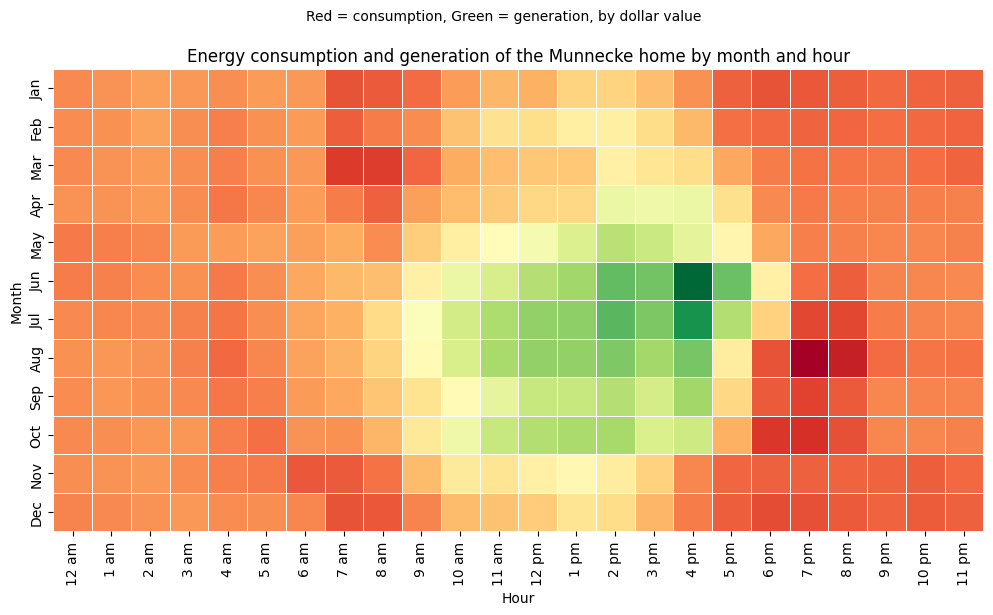

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def show_summary():
    # Load the data
    df = pd.read_csv('docs/processed_data.csv', parse_dates=['Datetime'])
    df.set_index('Datetime', inplace=True)

    # Resample to hourly frequency and calculate average statistics
    hourly_data = df['$Net'].resample('H').sum()

    # Group by month and hour to calculate average
    heatmap_data = hourly_data.groupby([hourly_data.index.month, hourly_data.index.hour]).mean()

    # Unstack the data to create a matrix and transpose it
    heatmap_data = heatmap_data.unstack(level=0).T

    # Generate the heatmap
    plt.figure(figsize=(12, 6))

    # Create a list of month names for y-axis labels
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Create a list of hour labels in 'hh am/pm' format for x-axis labels
    hour_labels = [f"{hour % 12 if hour % 12 != 0 else 12} {'am' if hour < 12 else 'pm'}" for hour in range(24)]

    sns.heatmap(heatmap_data, cmap='RdYlGn_r', linewidths=0.5, yticklabels=month_names, xticklabels=hour_labels, cbar=False)

    plt.ylabel('Month')
    plt.xlabel('Hour')

    # Create a custom title with different colors for 'GENERATION' and 'CONSUMPTION'
    plt.title('Energy ', loc='left', color='black', fontsize=12)
    plt.title('GENERATION', color='red', fontsize=12)
    plt.title(' and ', loc='center', color='black', fontsize=12)
    plt.title('CONSUMPTION', color='green', fontsize=12)
    plt.title(' by Month and Hour of the Munnecke Home', loc='right', color='black', fontsize=12)

    plt.savefig('static/heatmap.png')

show_summary()
print ("done")

In [23]:
import pandas as pd
import plotly.figure_factory as ff

def show_summary():
    # Load the data
    df = pd.read_csv('docs/processed_data.csv', parse_dates=['Datetime'])
    df.set_index('Datetime', inplace=True)

    # Resample to hourly frequency and calculate average statistics
    hourly_data = df['$Net'].resample('H').sum()

    # Group by month and hour to calculate average
    heatmap_data = hourly_data.groupby([hourly_data.index.month, hourly_data.index.hour]).mean()

    # Unstack the data to create a matrix and transpose it
    heatmap_data = heatmap_data.unstack(level=0).T

    # Create a list of month names for y-axis labels
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

    # Create a list of hour labels in 'hh am/pm' format for x-axis labels
    hour_labels = [f"{hour % 12 if hour % 12 != 0 else 12} {'am' if hour < 12 else 'pm'}" for hour in range(24)]

    # Create the heatmap
    fig = ff.create_annotated_heatmap(z=heatmap_data.values, x=hour_labels, y=month_names, colorscale='RdYlGn', showscale=False)

    # Add title
    fig.update_layout(title_text='Energy consumption and generation of the Munnecke home by month and hour')

    # Show the plot
    fig.show()

In [6]:
!pip install jsonify

In [ ]:
# Install the extension
import jsonify

def generate_hexmap():
    # Load the data
    df = pd.read_csv('docs/processed_data.csv', parse_dates=['Datetime'])
    df.set_index('Datetime', inplace=True)

    # Resample to hourly frequency and calculate average statistics
    hourly_data = df['$Net'].resample('H').sum()

    # Group by month and hour to calculate average
    heatmap_data = hourly_data.groupby([hourly_data.index.month, hourly_data.index.hour]).mean()

    # Unstack the data to create a matrix and transpose it
    heatmap_data = heatmap_data.unstack(level=0).T

    # Convert the DataFrame to a list of dictionaries
    heatmap_data = heatmap_data.reset_index().to_dict('records')

    # Return the data as a JSON object
    return(heatmap_data)

generate_hexmap()




In [ ]:
import requests
import json

def get_pvwatts_data(system_capacity, timeframe, module_type, losses, array_type, tilt, azimuth, lat, lon):
    url = "https://developer.nrel.gov/api/pvwatts/v8.json"  # Changed to v8
    params = {
        'api_key': 'ef43dSIdvg397HVWEE9zfaoWd7UdesbxudgETPTn',
        'timeframe':timeframe,
        'system_capacity': system_capacity,
        'module_type': module_type,
        'losses': losses,
        'array_type': array_type,
        'tilt': tilt,
        'azimuth': azimuth,
        'lat': lat,
        'lon': lon,
    }
    response = requests.get(url, params=params)
    data = response.json()
   
    return data

panels = get_pvwatts_data(4.8, "hourly", 0, 19, 1, 23, 180, 33, -117)

print(json.dumps(panels, indent=4))


In [20]:
hourly_ac_generation = panels['outputs']['ac']
print(hourly_ac_generation)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 616.36, 1713.811, 2469.251, 2965.375, 3173.832, 3139.85, 2826.213, 2278.316, 1457.302, 238.196, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 626.29, 1731.629, 2485.73, 2956.46, 3161.019, 3113.054, 2817.154, 2267.275, 1433.013, 228.485, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 577.583, 1662.2, 2407.293, 2817.378, 3001.05, 2937.462, 2666.498, 2170.201, 1391.178, 228.146, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 625.064, 1724.452, 2463.086, 2948.125, 3164.597, 3110.999, 2824.8, 2285.327, 1459.631, 249.49, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 596.849, 1685.862, 2454.221, 2912.312, 3105.243, 3040.089, 2763.276, 2228.933, 1416.148, 255.811, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 571.948, 1635.37, 2331.552, 2720.168, 2904.812, 2914.823, 2694.431, 2210.154, 1429.824, 265.03, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

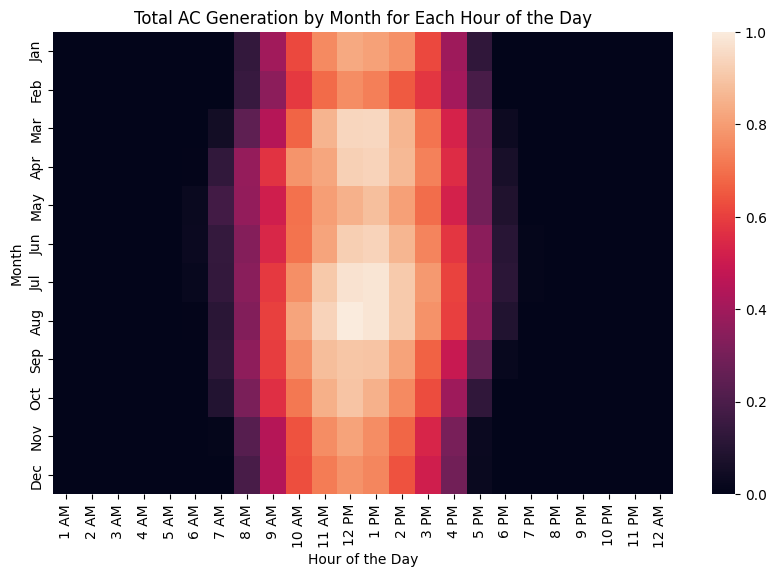

In [49]:
# Create a custom colormap
cmap = sns.color_palette("rocket", as_cmap=True)

# Normalize the data for the colormap
normalized_data = monthly_ac_generation / np.max(monthly_ac_generation)

# Create AM and PM labels
labels = [str(i) + ' AM' if i != 12 else str(i) + ' PM' for i in range(1, 13)] + [str(i) + ' PM' if i != 12 else str(i) + ' AM' for i in range(1, 13)]

# Create a heatmap with a color bar
plt.figure(figsize=(10, 6))
sns.heatmap(normalized_data, xticklabels=labels, yticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], cmap=cmap, cbar=True, vmin=0, vmax=1)
plt.xlabel('Hour of the Day')
plt.ylabel('Month')
plt.title('Total AC Generation by Month for Each Hour of the Day')
plt.show()

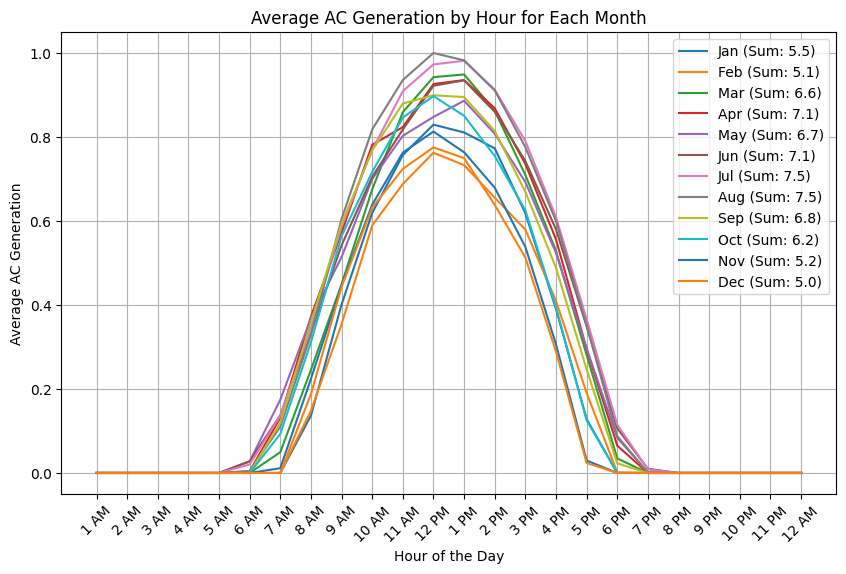

In [64]:
# Import necessary libraries
import pandas as pd

# Assume `daily_data` is a 2D array with 12 rows (one for each month) and 24 columns (one for each hour of the day)
daily_data = normalized_data

# Create a line plot for each month
plt.figure(figsize=(10, 6))
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for i in range(12):
    # Calculate the sum of the month's generation and round it to one decimal place
    month_sum = round(np.sum(daily_data[i]), 1)
    # Include the sum in the legend label
    plt.plot(daily_data[i], label=months[i] + ' (Sum: ' + str(month_sum) + ')')

# Create labels for the x-axis
x_labels = [str(i) + ' AM' if i != 12 else str(i) + ' PM' for i in range(1, 13)] + [str(i) + ' PM' if i != 12 else str(i) + ' AM' for i in range(1, 13)]

plt.xticks(range(24), x_labels, rotation=45)
plt.xlabel('Hour of the Day')
plt.ylabel('Average AC Generation')
plt.title('Average AC Generation by Hour for Each Month')
plt.grid(True)  # Add grid lines
plt.legend()
plt.show()